# Prelude to creating performance curves

**CODE FOR CREATING PERFORMANCE CURVES HAS BEEN MOVED TO performance_curves.py in mm_interpret project.**

The outputs of `performance_curves.py` are:

* `siminout_path/{perf_curve_scenarios_suffix}_obflow06_metainputs_pc.csv` 
* `matrix_data_path/X_performance_curves_{perf_curve_scenarios_suffix}.csv`

For example: `exp11d_obflow06_metainputs_pc,csv`

Here's the code from start of `main` in `performance_curves.py`. Yes, that code should get moved into a CLI.

```python
        mm_experiment_suffix = "exp11"
        perf_curve_scenarios_suffix = "exp11d"
        # Path to scenario yaml file created by scenario_grid.py
        path_scenario_grid_yaml = Path("mm_use", f"scenario_grid_{perf_curve_scenarios_suffix}.yaml")
        path_scenario_csv = Path("mm_use", f"X_performance_curves_{perf_curve_scenarios_suffix}.csv")
        siminout_path = Path("data/siminout")
        matrix_data_path = Path("data")
```

The key input is the YAML file specifying the scenario grid. Also, note that performance curves may be created before the scenarios have been simulated. In fact, they may never get simulated unless we want to compare predicted outputs to simulation outputs.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from pathlib import Path
import pickle
import itertools
import yaml

In [3]:
%matplotlib inline

## Data reading and prep

In [4]:
experiment = "exp11"
data_path = Path("data")
siminout_path = Path("data", "siminout")
mm_use_path = Path("mm_use")

In [5]:
output_path = "output"

obs_pkl_filename =  "obs_results_exp11.pkl"
ldr_pkl_filename =  "ldr_results_exp11.pkl"
pp_pkl_filename =  "pp_results_exp11.pkl"

obs_pkl_path = Path(output_path, obs_pkl_filename)
ldr_pkl_path = Path(output_path, ldr_pkl_filename)
pp_pkl_path = Path(output_path, pp_pkl_filename)

In [6]:
with open(ldr_pkl_path, 'rb') as pickle_file:
    ldr_results = pickle.load(pickle_file)

In [7]:
scenarios_io_df = pd.read_csv(Path(mm_use_path, "X_performance_curves_exp11c.csv"))
scenarios_io_df

,scenario,arrival_rate,mean_los_obs,cap_obs,mean_los_ldr,cap_ldr,mean_los_pp,c_sect_prob,cap_pp,load_obs,...,pred_condmeantime_blockedby_ldr_basicq_nn,pred_obs_occ_mean_q_nn,pred_obs_occ_p95_q_nn,pred_prob_blockedby_ldr_q_nn,pred_condmeantime_blockedby_ldr_q_nn,pred_obs_occ_mean_onlyq_lm,pred_obs_occ_p95_onlyq_lm,pred_prob_blockedby_ldr_onlyq_lm,pred_prob_blockedby_ldr_q_erlangc,pred_condmeantime_blockedby_ldr_onlyq_lm
0,1,0.3,2.4,1000,12.0,16,54.0,0.25,75,0.72,...,-39.872647,76.589387,121.300405,14.405808,40.238995,15.280992,22.623047,-0.017874,0.000001,0.648888
1,2,0.4,2.4,1000,12.0,16,54.0,0.25,75,0.96,...,-39.743398,76.935961,123.292788,13.864124,40.419625,20.368890,28.497356,-0.017827,0.000045,0.682729
2,3,0.5,2.4,1000,12.0,16,54.0,0.25,75,1.20,...,-39.633341,77.261573,124.961718,13.432766,40.539487,25.457038,34.198179,-0.017293,0.000534,0.741965
3,4,0.6,2.4,1000,12.0,16,54.0,0.25,75,1.44,...,-39.536918,77.548998,126.628728,13.114477,40.603573,30.546980,39.777510,-0.014199,0.003372,0.830407
4,5,0.7,2.4,1000,12.0,16,54.0,0.25,75,1.68,...,-39.450825,77.832922,128.231743,12.779608,40.649931,35.644882,45.271766,-0.002942,0.013696,0.955667
5,6,0.8,2.4,1000,12.0,16,54.0,0.25,75,1.92,...,-39.374668,78.171518,129.811922,12.436663,40.717463,40.767652,50.718001,0.025935,0.040180,1.128725
6,7,0.9,2.4,1000,12.0,16,54.0,0.25,75,2.16,...,-39.309648,78.561704,131.419822,11.947551,40.834776,45.948912,56.164164,0.081615,0.091245,1.361615
7,8,1.0,2.4,1000,12.0,16,54.0,0.25,75,2.40,...,-39.250253,78.920798,133.035424,11.380980,40.997166,51.237389,61.669146,0.165693,0.168354,1.663620
8,9,1.1,2.4,1000,12.0,16,54.0,0.25,75,2.64,...,-39.195657,79.145022,134.302876,10.730292,41.165340,56.697111,67.303947,0.272372,0.266192,2.056044
9,10,1.2,2.4,1000,12.0,16,54.0,0.25,75,2.88,...,-39.145219,78.925569,133.990082,9.784778,41.294426,62.536178,73.283572,0.410316,0.392703,2.701707


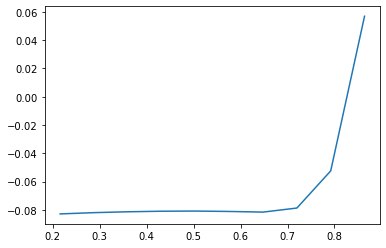

In [8]:
x = scenarios_io_df['rho_pp']
y = scenarios_io_df['pred_prob_blockedby_pp_q_lm']
plt.plot(x, y)

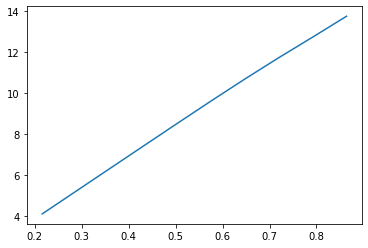

In [9]:
x = scenarios_io_df['rho_pp']
y = scenarios_io_df['pred_ldr_occ_mean_q_lassocv']
plt.plot(x, y)

## Comparing predicted perf curves to simulation results

* I created a scenario input file: `exp11c_obflow06_metainputs.csv`.
* Create a run settings file `input/exp11c_obflow06_settings.yaml`
* Edit (until I create a CLI) `obsimpy.create_configs.py` by setting experiment suffix. This then creates all the necessary path related variables. Make sure to create the new subdirs in logs and stats with same name as experiment suffix.
* Run `obsimpy.create_configs.py` that takes the scenario input file and run settings as input and then creates:
    - one obsimpy yaml config file for each scenario row
    - a bash script to run each simulation scenario and then runs `obflow_6_output.py` to post process the logs and stats  
    - results in `scenario_siminout_{perf_curve_scenarios_suffix}.csv`
    - we can import this csv file to provide the actual simulation based estimates of all the performance measures.





In [20]:
scenario_siminout_exp11c_df = pd.read_csv(Path(siminout_path, 'exp11c', 'scenario_siminout_exp11c.csv'), 
                                         index_col=0)

scenario_siminout_exp11d_df = pd.read_csv(Path(siminout_path, 'exp11d', 'scenario_siminout_exp11d.csv'), 
                                         index_col=0)

scenario_siminout_exp11e_df = pd.read_csv(Path(siminout_path, 'exp11e', 'scenario_siminout_exp11e.csv'), 
                                         index_col=0)

X_performance_curves_exp11c_df = pd.read_csv(Path(mm_use_path, 'X_performance_curves_exp11c.csv'), 
                                         index_col=0)

X_performance_curves_exp11d_df = pd.read_csv(Path(mm_use_path, 'X_performance_curves_exp11d.csv'), 
                                         index_col=0)

X_performance_curves_exp11e_df = pd.read_csv(Path(mm_use_path, 'X_performance_curves_exp11e.csv'), 
                                         index_col=0)

In [21]:
scenario_siminout_exp11c_df.head()

,arrival_rate,mean_los_obs,num_erlang_stages_obs,mean_los_ldr,num_erlang_stages_ldr,mean_los_csect,num_erlang_stages_csect,mean_los_pp_noc,mean_los_pp_c,num_erlang_stages_pp,...,occ_mean_p95_obs,occ_mean_p95_ldr,occ_mean_p95_csect,occ_mean_p95_pp,prob_blockedby_ldr,condmeantime_blockedby_ldr,condp95time_blockedby_ldr,prob_blockedby_pp,condmeantime_blockedby_pp,condp95time_blockedby_pp
scenario,,,,,,,,,,,,,,,,,,,,,
1,0.3,2.4,1,12,2,1,4,48,72,8,...,2.0,7.000000,1.0,23.066667,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,0.4,2.4,1,12,2,1,4,48,72,8,...,3.0,8.933333,1.0,29.466667,0.000040,0.210431,0.284092,0.0,0.0,0.0
3,0.5,2.4,1,12,2,1,4,48,72,8,...,3.0,10.066667,1.0,35.866667,0.000548,0.780137,1.628265,0.0,0.0,0.0
4,0.6,2.4,1,12,2,1,4,48,72,8,...,4.0,12.000000,1.0,41.966667,0.003070,1.101658,2.888380,0.0,0.0,0.0
5,0.7,2.4,1,12,2,1,4,48,72,8,...,4.0,13.266667,1.0,48.033333,0.012303,1.198448,3.238090,0.0,0.0,0.0


In [22]:
X_performance_curves_exp11c_df.head()

,arrival_rate,mean_los_obs,cap_obs,mean_los_ldr,cap_ldr,mean_los_pp,c_sect_prob,cap_pp,load_obs,rho_obs,...,pred_condmeantime_blockedby_ldr_basicq_nn,pred_obs_occ_mean_q_nn,pred_obs_occ_p95_q_nn,pred_prob_blockedby_ldr_q_nn,pred_condmeantime_blockedby_ldr_q_nn,pred_obs_occ_mean_onlyq_lm,pred_obs_occ_p95_onlyq_lm,pred_prob_blockedby_ldr_onlyq_lm,pred_prob_blockedby_ldr_q_erlangc,pred_condmeantime_blockedby_ldr_onlyq_lm
scenario,,,,,,,,,,,,,,,,,,,,,
1,0.3,2.4,1000,12.0,16,54.0,0.25,75,0.72,0.00072,...,-39.872647,76.589387,121.300405,14.405808,40.238995,15.280992,22.623047,-0.017874,0.000001,0.648888
2,0.4,2.4,1000,12.0,16,54.0,0.25,75,0.96,0.00096,...,-39.743398,76.935961,123.292788,13.864124,40.419625,20.368890,28.497356,-0.017827,0.000045,0.682729
3,0.5,2.4,1000,12.0,16,54.0,0.25,75,1.20,0.00120,...,-39.633341,77.261573,124.961718,13.432766,40.539487,25.457038,34.198179,-0.017293,0.000534,0.741965
4,0.6,2.4,1000,12.0,16,54.0,0.25,75,1.44,0.00144,...,-39.536918,77.548998,126.628728,13.114477,40.603573,30.546980,39.777510,-0.014199,0.003372,0.830407
5,0.7,2.4,1000,12.0,16,54.0,0.25,75,1.68,0.00168,...,-39.450825,77.832922,128.231743,12.779608,40.649931,35.644882,45.271766,-0.002942,0.013696,0.955667


Now merge the performance curves dataframe (which contains input vars and predictions) with the simulation inputs and outputs. Note that duplicate column names on the siminout table get `_sim` appended.

In [23]:
#performance_curves_exp11b_simout_df = X_performance_curves_exp11b_df.merge(scenario_siminout_exp11b_df, on='scenario', suffixes=[None, '_sim'])
performance_curves_exp11c_simout_df = X_performance_curves_exp11c_df.merge(scenario_siminout_exp11c_df, on='scenario', suffixes=[None, '_sim'])
performance_curves_exp11d_simout_df = X_performance_curves_exp11d_df.merge(scenario_siminout_exp11d_df, on='scenario', suffixes=[None, '_sim'])
performance_curves_exp11e_simout_df = X_performance_curves_exp11e_df.merge(scenario_siminout_exp11e_df, on='scenario', suffixes=[None, '_sim'])

In [14]:
for c in performance_curves_exp11c_simout_df.columns:
    print(c)

arrival_rate
mean_los_obs
cap_obs
mean_los_ldr
cap_ldr
mean_los_pp
c_sect_prob
cap_pp
load_obs
rho_obs
load_ldr
rho_ldr
load_pp
rho_pp
prob_blockedby_pp_approx
condmeantime_blockedby_pp_approx
prob_blockedby_ldr_approx
condmeantime_blockedby_ldr_approx
ldr_cv2_svctime
obs_eff_load
obs_eff_sqrtload
ldr_effmean_svctime_approx
sqrt_load_obs
sqrt_load_ldr
sqrt_load_pp
pred_ldr_occ_mean_q_lm
pred_ldr_occ_p95_q_lm
pred_prob_blockedby_pp_q_lm
pred_condmeantime_blockedby_pp_q_lm
pred_ldr_occ_mean_basicq_lm
pred_ldr_occ_p95_basicq_lm
pred_prob_blockedby_pp_basicq_lm
pred_condmeantime_blockedby_pp_basicq_lm
pred_ldr_occ_mean_noq_lm
pred_ldr_occ_p95_noq_lm
pred_prob_blockedby_pp_noq_lm
pred_condmeantime_blockedby_pp_noq_lm
pred_ldr_occ_mean_q_lassocv
pred_ldr_occ_p95_q_lassocv
pred_prob_blockedby_pp_q_lassocv
pred_condmeantime_blockedby_pp_q_lassocv
pred_ldr_occ_mean_noq_poly
pred_ldr_occ_p95_noq_poly
pred_prob_blockedby_pp_noq_poly
pred_condmeantime_blockedby_pp_noq_poly
pred_ldr_occ_mean_basicq

## Make plots

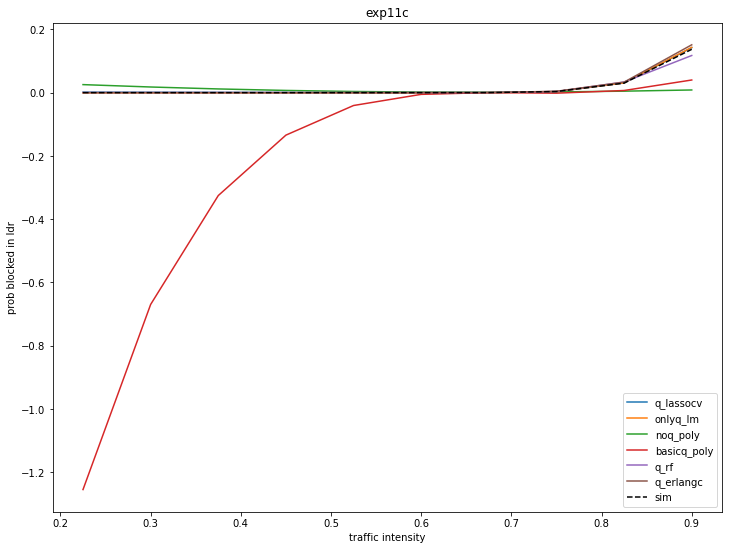

In [15]:
plt.figure(figsize=(12,9))
x = performance_curves_exp11c_simout_df['rho_ldr']
y1 = performance_curves_exp11c_simout_df['pred_prob_blockedby_pp_q_lassocv']
y2 = performance_curves_exp11c_simout_df['pred_prob_blockedby_pp_onlyq_lm']
y3 = performance_curves_exp11c_simout_df['pred_prob_blockedby_pp_noq_poly']
y4 = performance_curves_exp11c_simout_df['pred_prob_blockedby_pp_basicq_poly']
y5 = performance_curves_exp11c_simout_df['pred_prob_blockedby_pp_q_rf']
y6 = performance_curves_exp11c_simout_df['pred_prob_blockedby_pp_q_nn']
y7 = performance_curves_exp11c_simout_df['pred_prob_blockedby_pp_q_erlangc']
y8 = performance_curves_exp11c_simout_df['prob_blockedby_pp']
plt.plot(x, y1, label='q_lassocv')
plt.plot(x, y2, label='onlyq_lm')
plt.plot(x, y3, label='noq_poly')
plt.plot(x, y4, label='basicq_poly')
plt.plot(x, y5, label='q_rf')
#plt.plot(x, y6, label='q_nn')
plt.plot(x, y7, label='q_erlangc')
plt.plot(x, y8, 'k--', label='sim')
plt.title("exp11c")
plt.xlabel('traffic intensity')
plt.ylabel('prob blocked in ldr')
plt.legend()
plt.show()

In [ ]:
ldr_results['prob_blockedby_pp_onlyq_lm_results']['coeffs_df']

In [ ]:
plt.figure(figsize=(12,9))
x = performance_curves_exp11d_simout_df['rho_ldr']
y1 = performance_curves_exp11d_simout_df['pred_prob_blockedby_pp_q_lassocv']
y2 = performance_curves_exp11d_simout_df['pred_prob_blockedby_pp_onlyq_lm']
y3 = performance_curves_exp11d_simout_df['pred_prob_blockedby_pp_noq_poly']
y4 = performance_curves_exp11d_simout_df['pred_prob_blockedby_pp_basicq_poly']
y5 = performance_curves_exp11d_simout_df['pred_prob_blockedby_pp_q_rf']
y6 = performance_curves_exp11d_simout_df['pred_prob_blockedby_pp_q_erlangc']
y7 = performance_curves_exp11d_simout_df['prob_blockedby_pp']
plt.plot(x, y1, label='q_lassocv')
plt.plot(x, y2, label='onlyq_lm')
plt.plot(x, y3, label='noq_poly')
plt.plot(x, y4, label='basicq_poly')
plt.plot(x, y5, label='q_rf')
plt.plot(x, y6, label='q_erlangc')
plt.plot(x, y7, 'k--', label='sim')
plt.xlim(0.5, 1.0)
plt.title("exp11d")
plt.xlabel('traffic intensity')
plt.ylabel('prob blocked in ldr')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12,9))
x = performance_curves_exp11c_simout_df['rho_ldr']
y1 = performance_curves_exp11c_simout_df['pred_condmeantime_blockedby_pp_q_lassocv']
y2 = performance_curves_exp11c_simout_df['pred_condmeantime_blockedby_pp_onlyq_lm']
y3 = performance_curves_exp11c_simout_df['pred_condmeantime_blockedby_pp_noq_poly']
y4 = performance_curves_exp11c_simout_df['pred_condmeantime_blockedby_pp_basicq_poly']
y5 = performance_curves_exp11c_simout_df['pred_condmeantime_blockedby_pp_q_rf']
y6 = performance_curves_exp11c_simout_df['condmeantime_blockedby_pp']
plt.plot(x, y1, label='q_lassocv')
plt.plot(x, y2, label='onlyq_lm')
plt.plot(x, y3, label='noq_poly')
plt.plot(x, y4, label='basicq_poly')
plt.plot(x, y5, label='q_rf')
plt.plot(x, y6, 'k--', label='sim')
plt.title("exp11c")
plt.xlim(0.5, 1.0)
plt.xlabel('traffic intensity')
plt.ylabel('condmeantime blocked in ldr')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12,9))
x = performance_curves_exp11c_simout_df['rho_ldr']
y1 = performance_curves_exp11c_simout_df['pred_ldr_occ_mean_q_lassocv']
y2 = performance_curves_exp11c_simout_df['pred_ldr_occ_mean_onlyq_lm']
y3 = performance_curves_exp11c_simout_df['pred_ldr_occ_mean_noq_poly']
y4 = performance_curves_exp11c_simout_df['pred_ldr_occ_mean_basicq_poly']
y5 = performance_curves_exp11c_simout_df['pred_ldr_occ_mean_q_rf']
y6 = performance_curves_exp11c_simout_df['pred_ldr_occ_mean_q_nn']
y7 = performance_curves_exp11c_simout_df['occ_mean_mean_ldr']
plt.plot(x, y1, label='q_lassocv')
plt.plot(x, y2, label='onlyq_lm')
plt.plot(x, y3, label='noq_poly')
plt.plot(x, y4, label='basicq_poly')
plt.plot(x, y5, label='q_rf')
plt.plot(x, y6, label='q_nn')
plt.plot(x, y7, 'k--', label='sim')
plt.title("exp11c - occ mean ldr")
plt.xlabel('traffic intensity ldr')
plt.ylabel('mean occ ldr')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12,9))
x = performance_curves_exp11d_simout_df['rho_ldr']
y1 = performance_curves_exp11d_simout_df['pred_ldr_occ_mean_q_lassocv']
y2 = performance_curves_exp11d_simout_df['pred_ldr_occ_mean_onlyq_lm']
y3 = performance_curves_exp11d_simout_df['pred_ldr_occ_mean_noq_poly']
y4 = performance_curves_exp11d_simout_df['pred_ldr_occ_mean_basicq_poly']
y5 = performance_curves_exp11d_simout_df['pred_ldr_occ_mean_q_rf']
y6 = performance_curves_exp11d_simout_df['pred_ldr_occ_mean_q_nn']
y7 = performance_curves_exp11d_simout_df['occ_mean_mean_ldr']
plt.plot(x, y1, label='q_lassocv')
plt.plot(x, y2, label='onlyq_lm')
plt.plot(x, y3, label='noq_poly')
plt.plot(x, y4, label='basicq_poly')
plt.plot(x, y5, label='q_rf')
plt.plot(x, y6, label='q_nn')
plt.plot(x, y7, 'k--', label='sim')
plt.title("exp11d - occ mean ldr")
plt.xlabel('traffic intensity ldr')
plt.ylabel('mean occ ldr')
plt.legend()
plt.show()

I've confirmed that the nn's are fit using a Pipeline which includes StandardScaler as first step. Saved model object IS the pipeline. So predicting on new data should result in the StandardScaler being applied first to the new new data and then the scaled data fed to the fit neural net. It's just hard to believe the predictions could be this bad. However, lassocv also used scaled data with a pipeline and it predicts beautifully.

**TODO: Isolate a single neural net example to prove it really does fit this bad.**

In [ ]:
plt.figure(figsize=(12,9))
x = performance_curves_exp11c_simout_df['rho_ldr']
y1 = performance_curves_exp11c_simout_df['pred_ldr_occ_p95_q_lassocv']
y2 = performance_curves_exp11c_simout_df['pred_ldr_occ_p95_onlyq_lm']
y3 = performance_curves_exp11c_simout_df['pred_ldr_occ_p95_noq_poly']
y4 = performance_curves_exp11c_simout_df['pred_ldr_occ_p95_basicq_poly']
y5 = performance_curves_exp11c_simout_df['pred_ldr_occ_p95_q_rf']
y6 = performance_curves_exp11c_simout_df['occ_mean_p95_ldr']
plt.plot(x, y1, label='q_lassocv')
plt.plot(x, y2, label='onlyq_lm')
plt.plot(x, y3, label='noq_poly')
plt.plot(x, y4, label='basicq_poly')
plt.plot(x, y5, label='q_rf')
plt.plot(x, y6, 'k--', label='sim')
plt.title("exp11c - occ p95 ldr")
plt.xlabel('traffic intensity ldr')
plt.ylabel('p95 occ ldr')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12,9))
x = performance_curves_exp11d_simout_df['rho_ldr']
y1 = performance_curves_exp11d_simout_df['pred_ldr_occ_p95_q_lassocv']
y2 = performance_curves_exp11d_simout_df['pred_ldr_occ_p95_onlyq_lm']
y3 = performance_curves_exp11d_simout_df['pred_ldr_occ_p95_noq_poly']
y4 = performance_curves_exp11d_simout_df['pred_ldr_occ_p95_basicq_poly']
y5 = performance_curves_exp11d_simout_df['pred_ldr_occ_p95_q_rf']
y6 = performance_curves_exp11d_simout_df['occ_mean_p95_ldr']
plt.plot(x, y1, label='q_lassocv')
plt.plot(x, y2, label='onlyq_lm')
plt.plot(x, y3, label='noq_poly')
plt.plot(x, y4, label='basicq_poly')
plt.plot(x, y5, label='q_rf')
plt.plot(x, y6, 'k--', label='sim')
plt.title("exp11d - occ p95 ldr")
plt.xlabel('traffic intensity ldr')
plt.ylabel('p95 occ ldr')
plt.legend()
plt.show()

In [ ]:
ldr_results['ldr_occ_p95_q_lassocv_results'].keys()

In [ ]:
ldr_results['ldr_occ_p95_q_lassocv_results']['coeffs_df'].transpose()

Look at q_lasso. It does terribly on low traffic values because in the original training data, the 95%ile of occupancy could be well predicted by the capacity of the unit. So, in low traffic, it overpredicts dramatically whereas the onlyq_lm does quite well.

So, why then do nn, rf and svr perform so poorly when all they need to do is discover a single variable regression model (for mean occ using load) or a almost as simple load + z * sqrt(load) model? Is it just overfitting?

## Exp11e - use OB model for an ICU-PCU-RMF flow

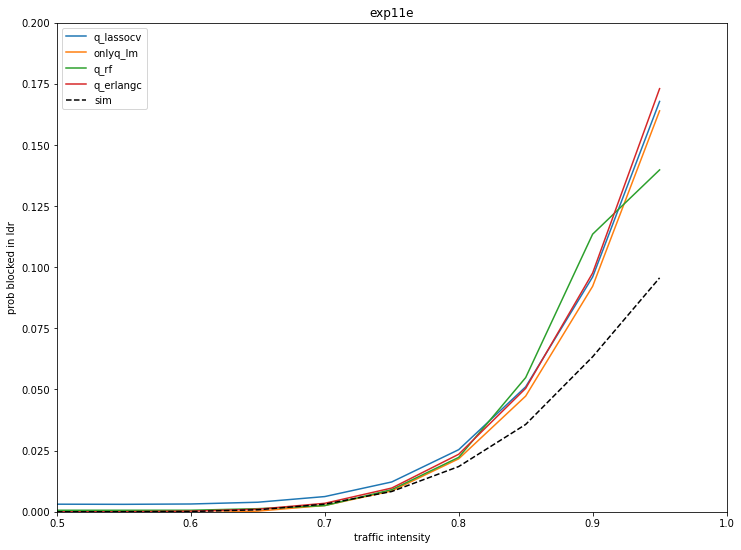

In [33]:
plt.figure(figsize=(12,9))
x = performance_curves_exp11e_simout_df['rho_ldr']
y1 = performance_curves_exp11e_simout_df['pred_prob_blockedby_pp_q_lassocv']
y2 = performance_curves_exp11e_simout_df['pred_prob_blockedby_pp_onlyq_lm']
y3 = performance_curves_exp11e_simout_df['pred_prob_blockedby_pp_noq_poly']
y4 = performance_curves_exp11e_simout_df['pred_prob_blockedby_pp_basicq_poly']
y5 = performance_curves_exp11e_simout_df['pred_prob_blockedby_pp_q_rf']
y6 = performance_curves_exp11e_simout_df['pred_prob_blockedby_pp_q_nn']
y7 = performance_curves_exp11e_simout_df['pred_prob_blockedby_pp_q_erlangc']
y8 = performance_curves_exp11e_simout_df['prob_blockedby_pp']
plt.plot(x, y1, label='q_lassocv')
plt.plot(x, y2, label='onlyq_lm')
#plt.plot(x, y3, label='noq_poly')
#plt.plot(x, y4, label='basicq_poly')
plt.plot(x, y5, label='q_rf')
plt.plot(x, y7, label='q_erlangc')
#plt.plot(x, y6, label='q_nn')
plt.plot(x, y8, 'k--', label='sim')
plt.title("exp11e")
plt.xlabel('traffic intensity')
plt.ylabel('prob blocked in ldr')
plt.legend()
plt.xlim(0.5, 1.0)
plt.ylim(0.0, 0.2)
plt.show()

It seems a bit odd to get this level of overprediction. PP should look pretty much like an MGc queue and the erlangc should do pretty well. Confirm that we are computing the pct blocked stat correctly from the simulation output. See below. I think this is because the whole tandem queue is getting blocked up at obs for high traffic intensities. Let's try exp11f with cap_obs = 30, cap_ldr = 20, cap_pp = 35. Will force me to streamline and document the steps to run a new scenario.

In addition, the original exp11 experimental design had max rho ~ 0.82.

In [26]:
stop_log = pd.read_csv('raw_sim_output/unit_stop_log_scenario_10_rep_25.csv')
stop_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42450 entries, 0 to 42449
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   patient_id        42450 non-null  int64  
 1   patient_type      42450 non-null  int64  
 2   unit              42450 non-null  object 
 3   request_entry_ts  42450 non-null  float64
 4   entry_ts          42450 non-null  float64
 5   request_exit_ts   42450 non-null  float64
 6   exit_ts           42450 non-null  float64
 7   planned_los       42450 non-null  float64
 8   adjusted_los      42450 non-null  float64
 9   entry_tryentry    42450 non-null  float64
 10  tryexit_entry     42450 non-null  float64
 11  exit_tryexit      42450 non-null  float64
 12  exit_enter        42450 non-null  float64
 13  exit_tryenter     42450 non-null  float64
 14  wait_to_enter     42450 non-null  float64
 15  wait_to_exit      42450 non-null  float64
 16  bwaited_to_enter  42450 non-null  bool  

In [31]:
stop_log.groupby(['unit', 'bwaited_to_enter']).size().groupby(['unit']).apply(lambda x:
                                                 x / float(x.sum()))

unit  bwaited_to_enter
LDR   False               0.544028
      True                0.455972
OBS   False               0.006078
      True                0.993922
PP    False               0.899223
      True                0.100777
dtype: float64

In [29]:
1426/12724

0.11207167557371896

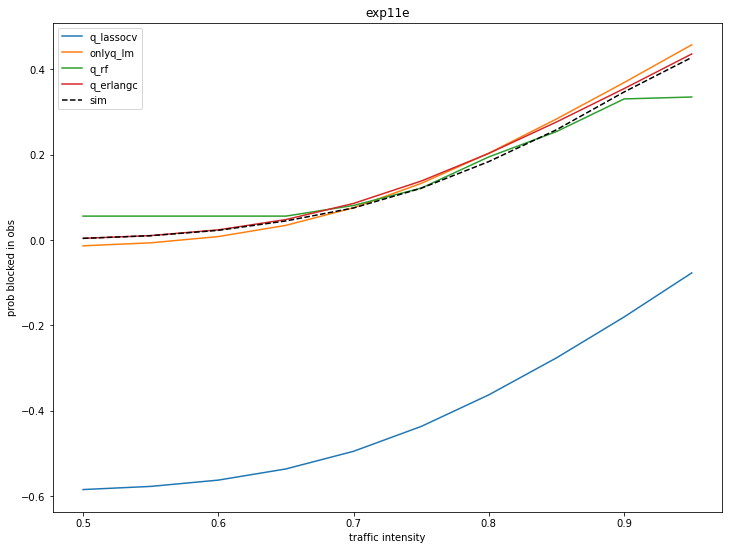

In [25]:
plt.figure(figsize=(12,9))
x = performance_curves_exp11e_simout_df['rho_ldr']
y1 = performance_curves_exp11e_simout_df['pred_prob_blockedby_ldr_q_lassocv']
y2 = performance_curves_exp11e_simout_df['pred_prob_blockedby_ldr_onlyq_lm']
y3 = performance_curves_exp11e_simout_df['pred_prob_blockedby_ldr_noq_poly']
y4 = performance_curves_exp11e_simout_df['pred_prob_blockedby_ldr_basicq_poly']
y5 = performance_curves_exp11e_simout_df['pred_prob_blockedby_ldr_q_rf']
y6 = performance_curves_exp11e_simout_df['pred_prob_blockedby_ldr_q_erlangc']
y7 = performance_curves_exp11e_simout_df['prob_blockedby_ldr']
plt.plot(x, y1, label='q_lassocv')
plt.plot(x, y2, label='onlyq_lm')
#plt.plot(x, y3, label='noq_poly')
#plt.plot(x, y4, label='basicq_poly')
plt.plot(x, y5, label='q_rf')
plt.plot(x, y6, label='q_erlangc')
plt.plot(x, y7, 'k--', label='sim')
plt.title("exp11e")
plt.xlabel('traffic intensity')
plt.ylabel('prob blocked in obs')
plt.legend()
plt.show()

If you look at the coeff plot for q_lassocv you'll see it uses the queueing approx terms with positive coeffs and then several other variables with negative coeffs. This resulted in good performance within the original experimental design but terrible performance for this out of design scenario.

## Variable importance in the RF models
This might be interesting to look at. Does it jive with our queueing knowledge?

## Boosted regression trees
Do algos exist in sklearn for these?

## Scratch pad

In [ ]:
'a' + 'b'

In [ ]:
max(0, -2)

In [ ]:
np.arange(.3, 1.4, 0.1).tolist()

In [ ]:
mm_experiment_suffix = "exp11"
perf_curve_scenarios_suffix = "exp11d"
path_scenario_grid_yaml = Path("mm_use", f"scenario_grid_{perf_curve_scenarios_suffix}.yaml")
path_scenario_df = Path("mm_use", f"X_performance_curves_{perf_curve_scenarios_suffix}.csv")
raw_data_path = Path("data/siminout")

with open(path_scenario_grid_yaml, "r") as stream:
    try:
        scenario_grid = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

print(scenario_grid)

In [ ]:
#pd.DataFrame(scenario_grid)

In [ ]:
for t in itertools.product([0, 1], [2, 4]):
    print(t)

In [ ]:
for t in itertools.product(*[[0, 1], [2, 4]]):
    print(t)

In [ ]:
[value for key, value in scenario_grid.items()]

In [ ]:
for t in itertools.product(*[value for key, value in scenario_grid.items()]):
    print(t)

In [ ]:
input_scenarios =  [scn for scn in itertools.product(*[value for key, value in scenario_grid.items()])]
input_scenarios

In [ ]:
input_scenarios = [scn for scn in itertools.product(
    arrival_rate, mean_los_obs, cap_obs, mean_los_ldr, mean_los_csect, cap_ldr,
    mean_los_pp_noc, mean_los_pp_c, c_sect_prob, cap_pp,
    num_erlang_stages_obs, num_erlang_stages_ldr, num_erlang_stages_pp, num_erlang_stages_csect)]

In [ ]:
cols = ['arrival_rate', 'mean_los_obs', 'cap_obs', 'mean_los_ldr', 'mean_los_csect', 'cap_ldr',
        'mean_los_pp_noc', 'mean_los_pp_c', 'c_sect_prob', 'cap_pp',
        'num_erlang_stages_obs', 'num_erlang_stages_ldr',
        'num_erlang_stages_pp', 'num_erlang_stages_csect']